#Transfer Learning
The most amount of layers that our trained models have had until now is 5, but what if we could build our model with 50 convolution layers?
And the most amount of data we have had would be in 10s of MBs, but what if we had 100s of GBs of data or even more?
Even if we had both, data and the convolution layers, we most probably wouldn't have the computation power.
Okay! Lets say we had that computation power and storage, inorder to train such a deep network with 50 layers and 100s of GBs of data, it would take days or maybe weeks.

That is where transfer learning comes in.
There are good people out there somewhere in the world who have used their computation power and trained such a network which we can use for our classification problem.

*HOW ON EARTH CAN I USE SOMEONE ELSE'S NETWORK?
IT MUST HAVE BEEN TRAINED ON DIFFERENT DATA. HECK, IT WOULDN'T EVEN HAVE THE SAME NUMBER OF OUTPUT CLASSES LIKE MINE. HOW IS THIS POSSIBLE????!!* 

The most important aspect of a neural network are it's weights or parameters.
With transfer learning, we keep those weights intact and just 'freeze' them, these forzen layers are our convolutional layers. We don't use the DNN or the fully connected part of the pre trained model. We use our own with the amount of classes that we need. Also we use our own data. And this technique works best when you have less amount of data. 
This is intuitive, suppose we had a lot of data like 100GB and we trained a CNN with 5 layers, the model would perform well because of the amount of data we have. On the other hand, if we had 100MB of data and used 5 layers our model would perform really bad, so we increase the number of layers to make it perform better.


NOTE: We don't have to freeze or even use all the layers of the pre-trained model. Suppose a model has 50 layers and we only want 20 we can use only those layers and freeze them and add our FCN after the 20th layer.

To implement transfer learning, 
1. We will import the skeleton of the pre-trained model
2. We will get the file with the weights of the pre-trained model
3. We will load the weights into the skeleton of the model
4. We will add our own fully connected network with the number of classes we want.
5. We will train the network.

In [1]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model

# Skeleton of pre-trained model
from tensorflow.keras.applications.inception_v3 import InceptionV3



In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

# Weights of the pre-trained model
weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

--2020-09-14 15:03:50--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 74.125.204.128, 64.233.187.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  27.0MB/s    in 3.1s    

2020-09-14 15:03:54 (27.0 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [4]:
pre_trained_model = InceptionV3(input_shape=(150,150,3),
                                include_top=False, # To not include the FCN of the model
                                weights=None)
# Loading the weights into the skeleton
pre_trained_model.load_weights(weights_file)

# Freezing these layers
for layer in pre_trained_model.layers:
  layer.trainable = False

# Uncomment this too see the summary
# pre_trained_model.summary()

# This is the layer in the convolution part of the network
# We need this to add our own FCN to the bottom of teh network
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [5]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

#                        CNN            FCN
model = Model( pre_trained_model.input,  x  ) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

Inorder to train our model we need data so let use prepare our data i.e, label it, augment it and just use the ImageDataGenerator

In [6]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

--2020-09-14 15:14:03--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   121MB/s    in 0.5s    

2020-09-14 15:14:04 (121 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [7]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 156s - loss: 0.3170 - accuracy: 0.8740 - val_loss: 0.1462 - val_accuracy: 0.9470
Epoch 2/20
100/100 - 150s - loss: 0.2181 - accuracy: 0.9175 - val_loss: 0.1146 - val_accuracy: 0.9580
Epoch 3/20
100/100 - 151s - loss: 0.2006 - accuracy: 0.9245 - val_loss: 0.1104 - val_accuracy: 0.9610
Epoch 4/20
100/100 - 152s - loss: 0.1863 - accuracy: 0.9315 - val_loss: 0.1094 - val_accuracy: 0.9620
Epoch 5/20
100/100 - 155s - loss: 0.1879 - accuracy: 0.9330 - val_loss: 0.2707 - val_accuracy: 0.9280
Epoch 6/20
100/100 - 151s - loss: 0.1980 - accuracy: 0.9330 - val_loss: 0.1011 - val_accuracy: 0.9700
Epoch 7/20
100/100 - 151s - loss: 0.1618 - accuracy: 0.9400 - val_loss: 0.1700 - val_accuracy: 0.9500
Epoch 8/20
100/100 - 151s - loss: 0.1796 - accuracy: 0.9445 - val_loss: 0.1353 - val_accuracy: 0.9580
Epoch 9/20
100/100 - 154s - loss: 0.1703 - accuracy: 0.9420 - val_loss: 0.1209 - val_accuracy: 0.9650
Epoch 10/20
100/100 - 151s - loss: 0.1892 - accuracy: 0.9425 - val_loss: 0.1170 - 

Text(0.5, 1.0, 'Training loss vs. Validation loss')

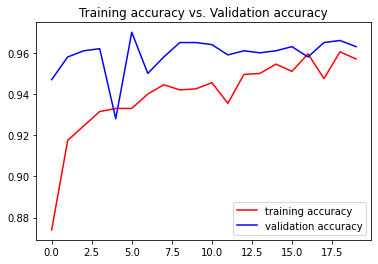

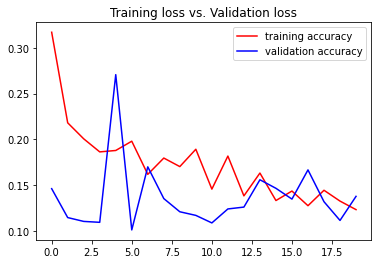

In [8]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='training accuracy')
plt.plot(epochs, val_acc, 'b', label='validation accuracy')
plt.legend()
plt.title('Training accuracy vs. Validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='training accuracy')
plt.plot(epochs, val_loss, 'b', label='validation accuracy')
plt.legend()
plt.title('Training loss vs. Validation loss')

In [12]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np

uploaded = files.upload()

for file_name in uploaded.keys():
  path = '/content/' + file_name
  img = image.load_img(path, target_size=(150,150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(file_name + " is a dog")
  else:
    print(file_name + " is a cat")

Saving cat.jpg to cat (3).jpg
Saving images.jpg to images (2).jpg
[4.6340265e-06]
cat.jpg is a cat
[0.]
images.jpg is a cat
